# The Simpsons

## Preparations

### Import libraries

- Tensorflow: Machine Learning Library
- Matplotlib: Plotting (math) library

In [39]:
import tensorflow as tf
from matplotlib import image
from tensorflow.keras import datasets, layers, models, Sequential
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import itertools
import glob
from sklearn import preprocessing, metrics

In [40]:
import warnings

#warnings.filterwarnings('ignore')

### Select Characters

Create a list of characters that we want to recognise

In [41]:
characters = [
    # "abraham_grampa_simpson", not same images
    # "agnes_skinner", only ~50 images
    "apu_nahasapeemapetilon",
    # "barney_gumble", only ~100 images
    "bart_simpson",
    # "carl_carlson", only ~100 images
    "charles_montgomery_burns",
    "chief_wiggum",
    # "cletus_spuckler", only ~50 images
    # "comic_book_guy", great confusion
    # "disco_stu", only 8 (!) images
    "edna_krabappel",
    # "fat_tony", only ~30 images
    # "gil", only ~30 images
    #"groundskeeper_willie", only ~120 images
    "homer_simpson",
    "kent_brockman",
    "krusty_the_clown",
    # "lenny_leonard", great confusion
    # "lionel_hutz", only 3 (!!!) images
    "lisa_simpson",
    # "maggie_simpson", only ~120 images
    "marge_simpson",
    # "martin_prince", only ~120 images
    # "mayor_quimby", only ~250 images
    "milhouse_van_houten",
    # "miss_hoover", only ~20 images
    "moe_szyslak",
    "ned_flanders",
    # "nelson_muntz", great confusion
    # "otto_mann", only ~30 images
    # "patty_bouvier", only ~70 images
    "principal_skinner",
    # "professor_john_frink", only ~70 images
    # "rainier_wolfcastle", only ~50 images
    # "ralph_wiggum", only ~90 images
    # "selma_bouvier", only ~100 images
    "sideshow_bob",
    # "sideshow_mel", only ~40 images
    # "snake_jailbird", only ~50 images
    # "troy_mcclure", only 8 (!) images
    # "waylon_smithers", only ~180 images
]

In [42]:
#Randomly pick characters for testing
import random

number_of_characters = len(characters)

selected_characters = random.sample(characters, number_of_characters)
print(selected_characters)

['marge_simpson', 'principal_skinner', 'apu_nahasapeemapetilon', 'krusty_the_clown', 'chief_wiggum', 'bart_simpson', 'sideshow_bob', 'edna_krabappel', 'homer_simpson', 'lisa_simpson', 'charles_montgomery_burns', 'ned_flanders', 'milhouse_van_houten', 'moe_szyslak', 'kent_brockman']


## Labeling for CNN

In [43]:
encoded_labels = preprocessing.LabelEncoder()
encoded_labels.fit(selected_characters)

LabelEncoder()

### Directories

In [44]:
directories = {
    "data_directory": "./data/archive/",
}

directories["annotation_file"] = directories["data_directory"] + "annotation.txt"
directories["dataset"] = directories["data_directory"] + "simpsons_dataset/"
directories["testset"] = directories["data_directory"] + "kaggle_simpson_testset/kaggle_simpson_testset/"

## Previewing the characters

<Figure size 720x720 with 0 Axes>

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'marge_simpson')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'principal_skinner')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'apu_nahasapeemapetilon')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'krusty_the_clown')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'chief_wiggum')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'bart_simpson')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'sideshow_bob')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'edna_krabappel')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'homer_simpson')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'lisa_simpson')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'charles_montgomery_burns')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'ned_flanders')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'milhouse_van_houten')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'moe_szyslak')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'kent_brockman')

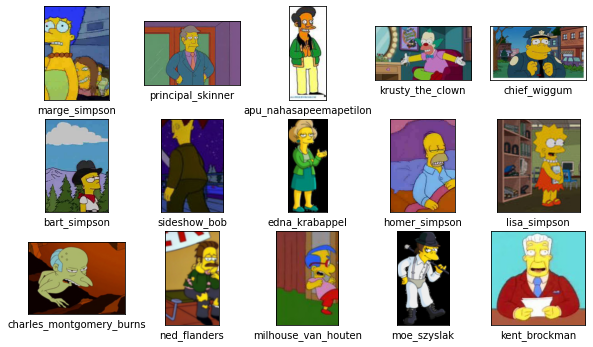

In [45]:
plt.figure(figsize=(10, 10))
for iterator, character_name in enumerate(selected_characters):
    plt.subplot(5, 5, iterator + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = image.imread(directories["dataset"] + character_name + "/pic_0000.jpg")
    plt.imshow(img)
    plt.xlabel(character_name)
plt.show()

## Resizing Images
For testing this code creates the same as above but resized to the standard_resolution variable

In [46]:
standard_resolution = 352
resampling_algorithm = Image.LANCZOS  # todo decide on resampling algorithm

In [47]:
def get_resized_image(image_path):
    img = Image.open(image_path)
    img = img.resize(size=(standard_resolution, standard_resolution),
                     resample=resampling_algorithm)
    img = np.asarray(img)  #store im as numpy array
    # shape of image is ([128x(r,g,b)], [128x(r,g,b)])
    img = np.array(img)
    return img

<Figure size 720x720 with 0 Axes>

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'marge_simpson')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'principal_skinner')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'apu_nahasapeemapetilon')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'krusty_the_clown')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'chief_wiggum')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'bart_simpson')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'sideshow_bob')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'edna_krabappel')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'homer_simpson')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'lisa_simpson')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'charles_montgomery_burns')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'ned_flanders')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'milhouse_van_houten')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'moe_szyslak')

<AxesSubplot:>

([], [])

([], [])

Text(0.5, 0, 'kent_brockman')

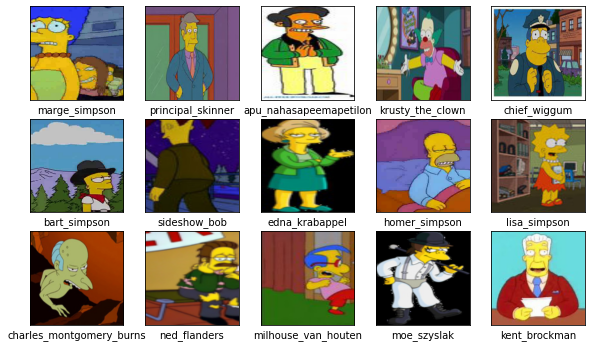

In [48]:
plt.figure(figsize=(10, 10))
for iterator, character_name in enumerate(selected_characters):
    plt.subplot(5, 5, iterator + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(get_resized_image(directories["dataset"] + character_name + "/pic_0000.jpg"))
    plt.xlabel(character_name)
plt.show()

## Load files and split into test data

In [49]:
test_factor = 0.2  # determine what percentage of each character's images should be used for testing

In [50]:
print(selected_characters)

['marge_simpson', 'principal_skinner', 'apu_nahasapeemapetilon', 'krusty_the_clown', 'chief_wiggum', 'bart_simpson', 'sideshow_bob', 'edna_krabappel', 'homer_simpson', 'lisa_simpson', 'charles_montgomery_burns', 'ned_flanders', 'milhouse_van_houten', 'moe_szyslak', 'kent_brockman']


In [51]:
training_images = []  # the images as rgb values
training_labels = []  # the corresponding character name

test_images = []  # the test images as rgb values
test_labels = []  # the corresponding character name

for character_name in selected_characters:  #loop over all selected characters

    current_character_path = directories["dataset"] + character_name + "/"
    current_character_paths_list = glob.glob(current_character_path + "*.jpg")

    # calculate how many files are test data and how many files are training data
    current_character_picture_count = len(current_character_paths_list)
    current_character_test_count = round(current_character_picture_count * test_factor)
    current_character_training_count = round(current_character_picture_count * (1 - test_factor))
    current_image_position = 0

    encoded_character_label = encoded_labels.transform([character_name])
    print("Loading Character:" + character_name + " (label number " + str(encoded_character_label[0]) + ")")
    print("", end='\n')

    for current_image_position, current_character_picture_path in enumerate(
            current_character_paths_list):  #loop over all files ending in .jpg in the current folder
        print("[", current_image_position, "/", current_character_picture_count, "]" + current_character_picture_path,
              end='\r')

        current_character_picture = get_resized_image(current_character_picture_path)  # load picture
        rand_int = random.randint(1,round(1/test_factor)) #random factor to decide if picture is training or test data
        if rand_int == 1:  # if rand_int is 1, the picture is added to the test_images
            test_images.append(current_character_picture)
            test_labels.append(encoded_character_label)
        else:
            training_images.append(current_character_picture)
            training_labels.append(encoded_character_label)
    print("", end='\n')

training_images = np.array(training_images)
training_labels = np.array(training_labels)
test_labels = np.array(test_labels)
test_images = np.array(test_images)

Loading Character:marge_simpson (label number 9)

[ 1290 / 1291 ]./data/archive/simpsons_dataset/marge_simpson/pic_0333.jpg
Loading Character:principal_skinner (label number 13)

[ 1193 / 1194 ]./data/archive/simpsons_dataset/principal_skinner/pic_0333.jpg
Loading Character:apu_nahasapeemapetilon (label number 0)

[ 622 / 623 ]./data/archive/simpsons_dataset/apu_nahasapeemapetilon/pic_0333.jpg
Loading Character:krusty_the_clown (label number 7)

[ 1205 / 1206 ]./data/archive/simpsons_dataset/krusty_the_clown/pic_0333.jpg
Loading Character:chief_wiggum (label number 3)

[ 985 / 986 ]./data/archive/simpsons_dataset/chief_wiggum/pic_0333.jpg
Loading Character:bart_simpson (label number 1)

[ 1341 / 1342 ]./data/archive/simpsons_dataset/bart_simpson/pic_0333.jpg
Loading Character:sideshow_bob (label number 14)

[ 876 / 877 ]./data/archive/simpsons_dataset/sideshow_bob/pic_0333.jpg
Loading Character:edna_krabappel (label number 4)

[ 456 / 457 ]./data/archive/simpsons_dataset/edna_krabappel

In [52]:
training_images[0].shape
len(training_images)
len(test_images)

(352, 352, 3)

13695

3557

## Create Convolutional Neuronal Network

In [53]:
model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(standard_resolution, standard_resolution, 3)),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(selected_characters), activation='relu')
])

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 352, 352, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 352, 352, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 352, 352, 8)       224       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 176, 176, 8)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 176, 176, 16)      1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 88, 88, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 88, 88, 32)       

In [55]:
#from sklearn.preprocessing import LabelEncoder

#df[target_col] = LabelEncoder().fit_transform(df[target_col])

In [56]:
#training_images, test_images = training_images / 255.0, test_images / 255.0

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # SparseCategoricalCrossentropy uses numbered labels instead of hot encoding (https://towardsdatascience.com/building-a-one-hot-encoding-layer-with-tensorflow-f907d686bf39)
    metrics=['accuracy']
)

history = model.fit(
    training_images, training_labels,
    epochs=10,
    validation_data=(test_images, test_labels)
)

Epoch 1/10
428/428 [==============================] - 301s 703ms/step - loss: 2.2567 - accuracy: 0.3005 - val_loss: 1.9535 - val_accuracy: 0.4180
Epoch 2/10
428/428 [==============================] - 323s 755ms/step - loss: 1.6505 - accuracy: 0.5181 - val_loss: 1.5061 - val_accuracy: 0.5693
Epoch 3/10
428/428 [==============================] - 325s 760ms/step - loss: 1.2899 - accuracy: 0.6257 - val_loss: 1.3101 - val_accuracy: 0.6264
Epoch 4/10
428/428 [==============================] - 324s 758ms/step - loss: 0.9887 - accuracy: 0.7107 - val_loss: 1.0517 - val_accuracy: 0.6983
Epoch 5/10
428/428 [==============================] - 320s 747ms/step - loss: 0.7781 - accuracy: 0.7736 - val_loss: 0.9460 - val_accuracy: 0.7385
Epoch 6/10
428/428 [==============================] - 322s 752ms/step - loss: 0.6543 - accuracy: 0.8096 - val_loss: 0.9571 - val_accuracy: 0.7436
Epoch 7/10
428/428 [==============================] - 317s 741ms/step - loss: 0.5772 - accuracy: 0.8377 - val_loss: 0.9051 -

## Export model

In [57]:
model.save_weights('./models/simpsons')

## Visualise the Network

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

(0.0, 1.0)

112/112 - 19s - loss: 0.9385 - accuracy: 0.7655


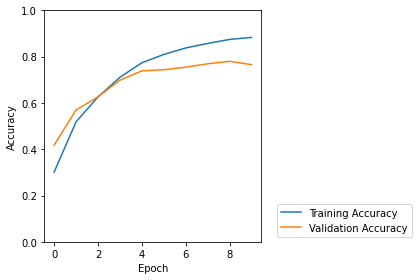

In [58]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0))
plt.tight_layout()
plt.savefig("accuracy.png", dpi=300)
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

(0.0, 2.0)

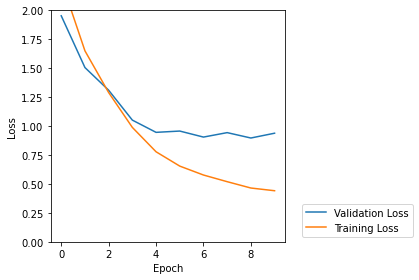

In [59]:
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0))
plt.tight_layout()
plt.savefig("loss.png", dpi=300)

## Load the test dataset

In [60]:
def load_test_set():
    pics, labels = [], []
    for all_test_pictures in glob.glob(directories["testset"] + '*.jpg'):
        file_name = all_test_pictures.split("/")[
            -1]  # './data/archive/kaggle_simpson_testset/kaggle_simpson_testset/principal_skinner_34.jpg'
        character_name_with_number = file_name.split(".jpg")[-2]  # 'principal_skinner_34'
        character_name_clean = character_name_with_number.rsplit('_', 1)[0]  # 'principal_skinner'

        if character_name_clean in selected_characters:
            character_label = encoded_labels.transform([character_name_clean])
            temp = get_resized_image(all_test_pictures)
            pics.append(temp)
            labels.append(character_label)
    x_test = np.array(pics)
    y_test = np.array(labels)
    print("Test set", x_test.shape, y_test.shape)
    return x_test, y_test

In [61]:
x_test, y_test = load_test_set()
prediction = model.predict(x_test)

Test set (743, 352, 352, 3) (743, 1)


## Confusion Matrix

<Figure size 720x720 with 0 Axes>

Text(0, 0.5, 'True label')

Text(0.5, 0, 'Predicted label')

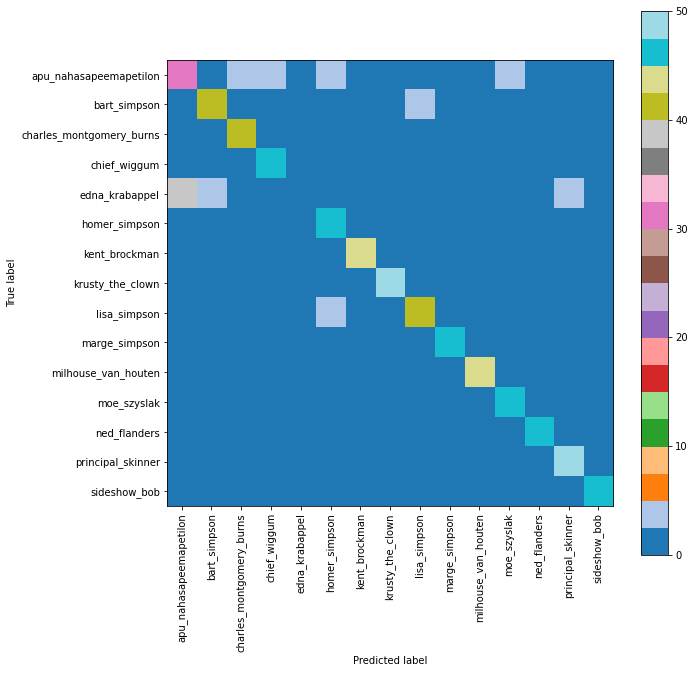

In [62]:
plt.figure(figsize=(10, 10))
labels = list(encoded_labels.classes_)
cm = metrics.confusion_matrix(y_test, np.argmax(prediction, axis=1))
tick_marks = np.arange(len(labels))
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.tab20)
plt.colorbar()
_ = plt.xticks(tick_marks, labels, rotation=90)
_ = plt.yticks(tick_marks, labels)
plt.savefig("confusion_matrix.png", dpi=300)
#p = metrics.ConfusionMatrixDisplay(cm, display_labels=labels).plot()

## Simple Predictions

In [75]:
prediction_images = []

random_choice = random.choice(selected_characters)
random_number = random.randint(0,30)

current_character_picture = get_resized_image(directories["testset"] + random_choice + "_" + str(random_number) + ".jpg")

#im = current_character_picture / 255.0
#img_array = tf.expand_dims(im, 0)  # Create a batch

img_array = tf.expand_dims(current_character_picture, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

#print(predictions[0])
#print(score)

#print(100 * np.max(score))

#print(np.argmax(predictions))
#print([labels[i] for i,prob in enumerate(predictions) if prob > 0.5])
print("Randomly chosen character: " + random_choice)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(encoded_labels.inverse_transform([np.argmax(score)])[0], 100 * np.max(score))
)

Randomly chosen character: sideshow_bob
This image most likely belongs to sideshow_bob with a 100.00 percent confidence.
